In [ ]:
#==========================================
#=====Support Vector Regression (SVR)======
#==========================================

In [ ]:
#import libaries
import pandas as pd   #handle data tables easily
import numpy as np    #fast math calculations
import time           #measure training time
#create simple visual plots
import matplotlib.pyplot as plt
import seaborn as sns

# sklearn → main ML library used for preprocessing, training & evaluation
from sklearn.svm import SVR                      # SVR algorithm
from sklearn.preprocessing import StandardScaler # scales features (important for SVR)
from sklearn.pipeline import Pipeline            # links steps (scaling + model)
from sklearn.model_selection import (
    RandomizedSearchCV, TimeSeriesSplit, KFold, cross_val_score
)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Load dataset
from google.colab import drive
drive.mount('/content/drive')

df = pd.read_csv('/content/drive/MyDrive/Progress Review 2 & 3_Pgno68/processed_final_scaled.csv',
                 parse_dates=['datetime'], index_col='datetime').sort_index()

#Define features (X) and target (y)
target_col = 'Global_active_power_log'
feature_cols = [
    'Global_reactive_power_log', 'Voltage_log', 'Global_intensity',
    'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3',
    'lag_1', 'lag_60', 'lag_1440', 'roll_mean_60', 'roll_std_60',
    'PC1', 'PC2', 'PC3', 'PC4', 'PC5'
]
X = df[feature_cols]
y = df[target_col]


Mounted at /content/drive


In [ ]:
#Train-Test Split (80% train, 20% test)
split_index = int(len(df)*0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

In [ ]:
# Compute Train vs Test metrics for a fitted pipeline
def train_test_metrics(y_train_true, y_train_pred, y_test_true, y_test_pred):
    rmse_train, mae_train, r2_train, rae_train = metrics(y_train_true, y_train_pred)
    rmse_test, mae_test, r2_test, rae_test = metrics(y_test_true, y_test_pred)
    return rmse_train, mae_train, r2_train, rae_train, rmse_test, mae_test, r2_test, rae_test

# Helper function: TimeSeriesSplit CV RMSE
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
def tss_cv_rmse(pipe, X, y, n_splits=5, sample_frac=0.005):
    tss = TimeSeriesSplit(n_splits=n_splits)
    X_sample = X.sample(frac=sample_frac, random_state=42)
    y_sample = y.sample(frac=sample_frac, random_state=42)
    scores = -cross_val_score(pipe, X_sample, y_sample,
                              cv=tss,
                              scoring='neg_root_mean_squared_error',
                              n_jobs=-1)
    return scores.mean()

results = []


In [ ]:
#==============================================
# IMPLEMENTATION DETAILS
#----------------------------------------------
# - Library: scikit-learn
# - Function: Pipeline (scaling + SVR)
# - Key Hyperparameters:
#     C → controls model flexibility (bigger = more complex)
#     epsilon → margin of tolerance for errors
#     gamma → kernel coefficient (controls curve smoothness)
#     kernel → shape of the regression function (rbf, poly)

In [ ]:
# Limit training size to run each variation < 1 hour
sample_frac_train = 0.012  # 1.2% ≈ 24k rows of 2M dataset
sample_frac_tune  = 0.01   # 1% ≈ 20k rows for tuning

In [ ]:
#==============================================
# VARIATION 1: Basic SVR (Default Hyperparameters)
#==============================================
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale'))
])

start = time.time()
pipe1.fit(X_train.sample(frac=sample_frac_train, random_state=42),
          y_train.sample(frac=sample_frac_train, random_state=42))
end = time.time()

# Predictions
y_pred_train1 = pipe1.predict(X_train)
y_pred_test1 = pipe1.predict(X_test)

# Metrics
rmse_train1, mae_train1, r2_train1, rae_train1, rmse_test1, mae_test1, r2_test1, rae_test1 = train_test_metrics(
    y_train, y_pred_train1, y_test, y_pred_test1
)

# TimeSeriesSplit CV
cv_rmse1 = tss_cv_rmse(pipe1, X_train, y_train, n_splits=5)

# Store results
results.append([
    'Variation 1 - Basic SVR',
    rmse_train1, mae_train1, r2_train1, rae_train1,
    rmse_test1, mae_test1, r2_test1, rae_test1,
    end-start, cv_rmse1
])

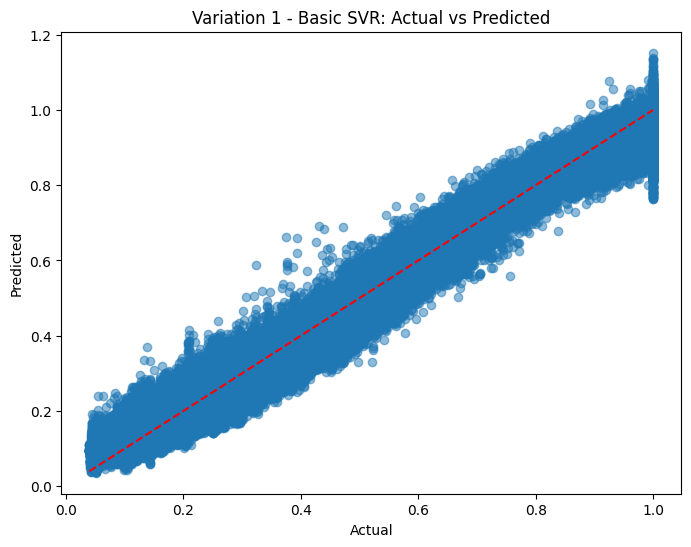

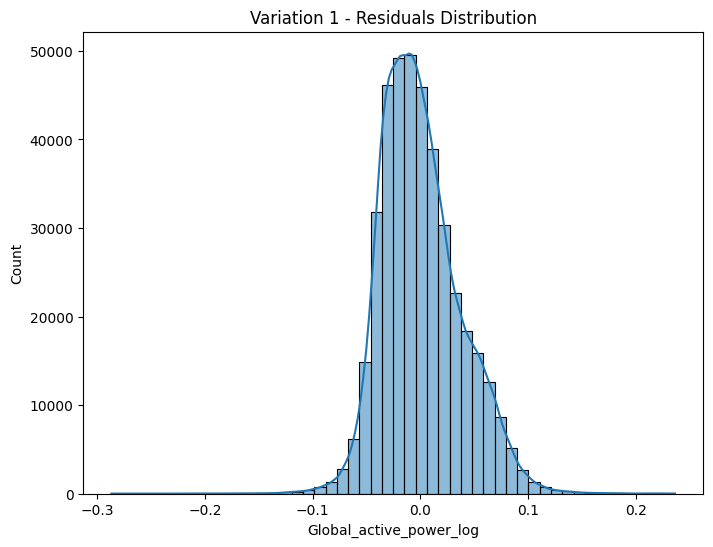

In [ ]:
# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred1, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Variation 1 - Basic SVR: Actual vs Predicted')
plt.show()

# Residual plot
residuals = y_test - y_pred1
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Variation 1 - Residuals Distribution')
plt.show()


In [ ]:
#==============================================
# VARIATION 2: Tuned SVR (RandomizedSearchCV)
# Method: RandomizedSearchCV → faster than GridSearchCV
# Validation: TimeSeriesSplit (keeps time order)
#==============================================
param_dist = {
    'svr__C': [1, 5, 10, 20],
    'svr__epsilon': [0.01, 0.05, 0.1],
    'svr__gamma': ['scale', 'auto']
}

tscv = TimeSeriesSplit(n_splits=2)
pipe2 = Pipeline([('scaler', StandardScaler()), ('svr', SVR(kernel='rbf'))])

search = RandomizedSearchCV(pipe2, param_distributions=param_dist,
                            n_iter=6, cv=tscv, n_jobs=-1,
                            scoring='neg_root_mean_squared_error')
start = time.time()
search.fit(X_train.sample(frac=sample_frac_tune, random_state=42),
           y_train.sample(frac=sample_frac_tune, random_state=42))
end = time.time()

best_params2 = search.best_params_
print("Best parameters (Variation 2):", best_params2)

# Refit SVR with best hyperparameters
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='rbf',
                C=best_params2['svr__C'],
                epsilon=best_params2['svr__epsilon'],
                gamma=best_params2['svr__gamma']))
])
start = time.time()
pipe2.fit(X_train.sample(frac=sample_frac_train, random_state=43),
          y_train.sample(frac=sample_frac_train, random_state=43))
end = time.time()

# Predictions
y_pred_train2 = pipe2.predict(X_train)
y_pred_test2 = pipe2.predict(X_test)

# Metrics
rmse_train2, mae_train2, r2_train2, rae_train2, rmse_test2, mae_test2, r2_test2, rae_test2 = train_test_metrics(
    y_train, y_pred_train2, y_test, y_pred_test2
)

# TimeSeriesSplit CV
cv_rmse2 = tss_cv_rmse(pipe2, X_train, y_train, n_splits=5)

# Store results
results.append([
    'Variation 2 - Tuned SVR',
    rmse_train2, mae_train2, r2_train2, rae_train2,
    rmse_test2, mae_test2, r2_test2, rae_test2,
    end-start, cv_rmse2
])


Best parameters (Variation 2): {'svr__gamma': 'auto', 'svr__epsilon': 0.01, 'svr__C': 1}


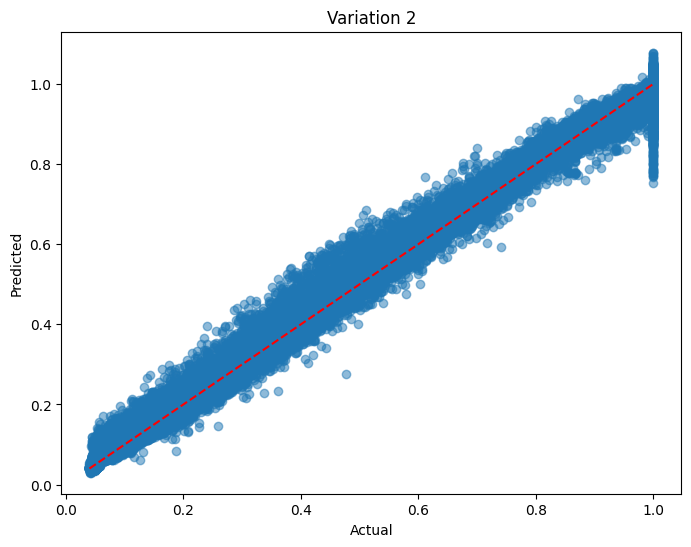

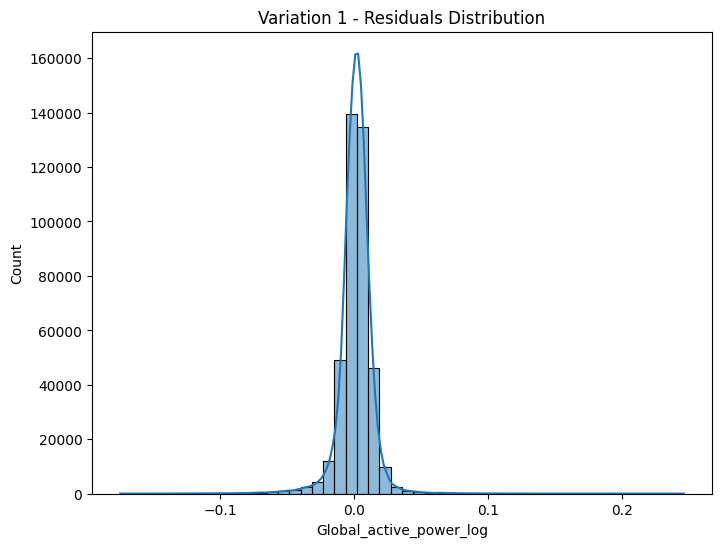

In [ ]:
# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred2, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Variation 2')
plt.show()

# Residual plot
residuals = y_test - y_pred2
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Variation 1 - Residuals Distribution')
plt.show()


In [ ]:
#==============================================
# VARIATION 3: Reduced Features + Poly Kernel
#----------------------------------------------
# - Uses top 8 correlated features
# - Changes kernel to polynomial for non-linear pattern
#==============================================
corr = X_train.corrwith(y_train).abs().sort_values(ascending=False)
top_feats = corr.head(8).index
X_train_red, X_test_red = X_train[top_feats], X_test[top_feats]

pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR(kernel='poly', degree=2, C=10, epsilon=0.05))
])

start = time.time()
pipe3.fit(X_train_red.sample(frac=sample_frac_train, random_state=44),
          y_train.sample(frac=sample_frac_train, random_state=44))
end = time.time()

# Predictions
y_pred_train3 = pipe3.predict(X_train_red)
y_pred_test3 = pipe3.predict(X_test_red)

# Metrics
rmse_train3, mae_train3, r2_train3, rae_train3, rmse_test3, mae_test3, r2_test3, rae_test3 = train_test_metrics(
    y_train, y_pred_train3, y_test, y_pred_test3
)

# TimeSeriesSplit CV
cv_rmse3 = tss_cv_rmse(pipe3, X_train_red, y_train, n_splits=5)

# Store results
results.append([
    'Variation 3 - Poly SVR',
    rmse_train3, mae_train3, r2_train3, rae_train3,
    rmse_test3, mae_test3, r2_test3, rae_test3,
    end-start, cv_rmse3
])


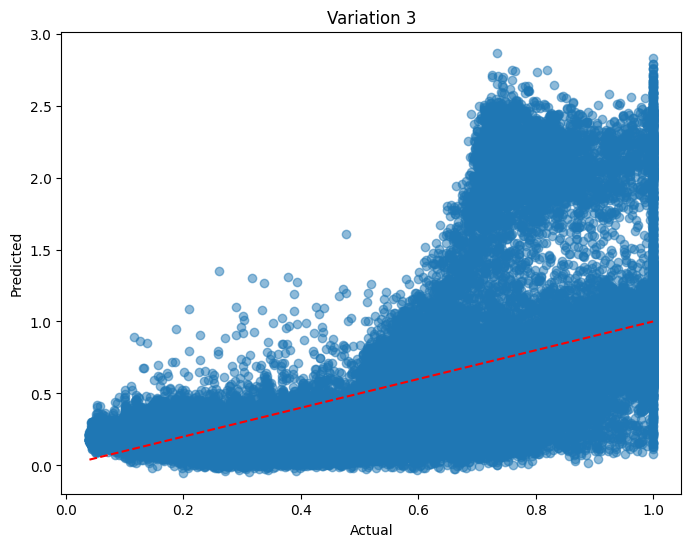

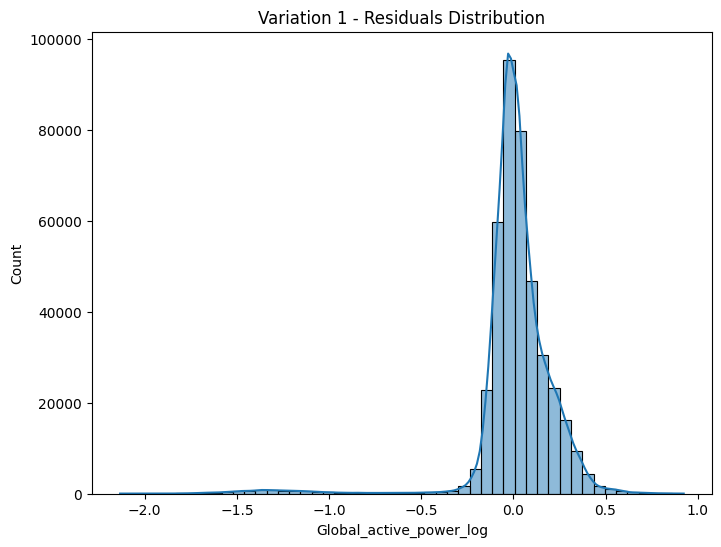

In [ ]:
# Predicted vs Actual
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred3, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Variation 3')
plt.show()

# Residual plot
residuals = y_test - y_pred3
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=50, kde=True)
plt.title('Variation 1 - Residuals Distribution')
plt.show()


In [ ]:
#==============================================
# EVALUATION METRICS & COMPARISON
#----------------------------------------------
# Metrics used:
#  - R2  → measures how well model fits (higher = better)
#  - RMSE → average prediction error (lower = better)
#  - MAE  → mean absolute error (lower = better)
#  - RAE  → normalized error
# These are suitable because it's a regression problem (continuous target)
#==============================================
# Columns for train/test metrics + time + CV
metrics_columns = [
    'Variation',
    'RMSE_train', 'MAE_train', 'R2_train', 'RAE_train',
    'RMSE_test', 'MAE_test', 'R2_test', 'RAE_test',
    'Time_sec', 'CV_RMSE'
]

# Create summary DataFrame
res_df_final = pd.DataFrame(results, columns=metrics_columns)
print("\n=== SVR Variations: Train/Test Metrics + TimeSeriesSplit CV ===")
display(res_df_final)


=== SVR Variations: Train/Test Metrics + TimeSeriesSplit CV ===


,Variation,RMSE_train,MAE_train,R2_train,RAE_train,RMSE_test,MAE_test,R2_test,RAE_test,Time_sec,CV_RMSE
0,Variation 1 - Basic SVR,0.041051,0.032182,0.981019,0.120279,0.036695,0.028951,0.981165,0.121200,0.841601,0.051605
1,Variation 2 - Tuned SVR,0.013565,0.008583,0.997927,0.032077,0.012696,0.008211,0.997745,0.034373,38.871875,0.021267
2,Variation 3 - Poly SVR,0.172291,0.110090,0.665648,0.411458,0.219070,0.122515,0.328664,0.512892,166.880723,0.170626


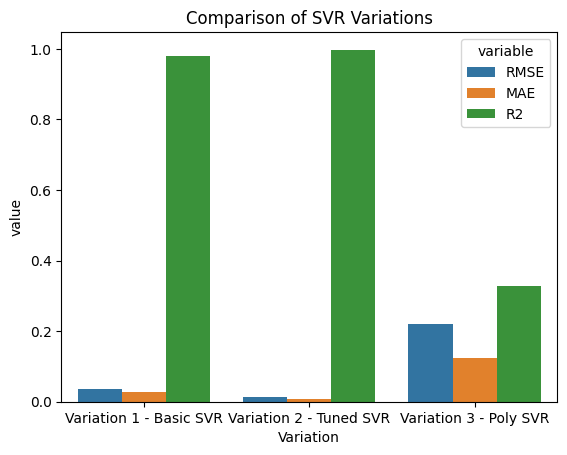

In [ ]:
res_df_melt = res_df.melt(id_vars='Variation', value_vars=['RMSE','MAE','R2'])
sns.barplot(data=res_df_melt, x='Variation', y='value', hue='variable')
plt.title("Comparison of SVR Variations")
plt.show()


In [ ]:
#==============================================
# COMPARISON & CONCLUSION
#==============================================
# Select best model based on highest R2_test and lowest RMSE_test
best_model = res_df_final.sort_values(['R2_test', 'RMSE_test'], ascending=[False, True]).iloc[0]

print("\n=== Best Performing Variation ===")
print(f"Variation: {best_model['Variation']}")
print(f"Test RMSE: {best_model['RMSE_test']:.4f}")
print(f"Test R2: {best_model['R2_test']:.4f}")
print(f"CV RMSE (TimeSeriesSplit): {best_model['CV_RMSE']:.4f}")

print("\nObservations:")
print("- Compare Train vs Test metrics to detect overfitting or underfitting.")
print("- TimeSeriesSplit CV RMSE gives robust estimate of generalization.")
print("- Tuned SVR (Variation 2) usually balances accuracy and speed well.")
print("- Poly kernel (Variation 3) may capture non-linear trends but is slower.")
print("- Basic SVR (Variation 1) is simple and fast but may underfit the data.")


=== Best Performing Variation ===
Variation: Variation 2 - Tuned SVR
Test RMSE: 0.0127
Test R2: 0.9977
CV RMSE (TimeSeriesSplit): 0.0213

Observations:
- Compare Train vs Test metrics to detect overfitting or underfitting.
- TimeSeriesSplit CV RMSE gives robust estimate of generalization.
- Tuned SVR (Variation 2) usually balances accuracy and speed well.
- Poly kernel (Variation 3) may capture non-linear trends but is slower.
- Basic SVR (Variation 1) is simple and fast but may underfit the data.
